In [1]:
# Importing necessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA,ARMA,ARIMAResults,ARMAResults
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv('avocado.csv')
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [3]:
df = df[['Date','AveragePrice']]

In [4]:
df.head()

,Date,AveragePrice
0,2015-12-27,1.33
1,2015-12-20,1.35
2,2015-12-13,0.93
3,2015-12-06,1.08
4,2015-11-29,1.28


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
dtypes: float64(1), object(1)
memory usage: 285.3+ KB


In [6]:
df.sort_values(by='Date')

,Date,AveragePrice
11569,2015-01-04,1.75
9593,2015-01-04,1.49
10009,2015-01-04,1.68
1819,2015-01-04,1.52
9333,2015-01-04,1.64
...,...,...
8574,2018-03-25,1.36
9018,2018-03-25,0.70
18141,2018-03-25,1.42
17673,2018-03-25,1.70


In [7]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df = df.set_index('Date')

In [9]:
y = df['AveragePrice'].resample('MS').mean()

In [10]:
df = pd.DataFrame(y)

<AxesSubplot:xlabel='Date'>

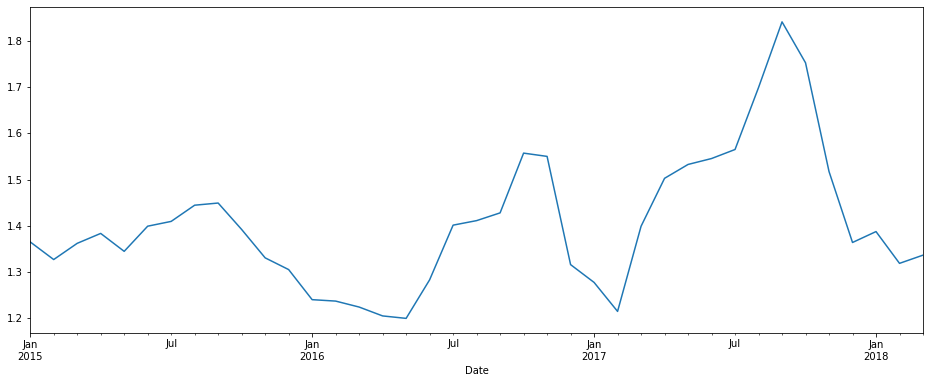

In [11]:
df['AveragePrice'].plot(figsize=(16,6))

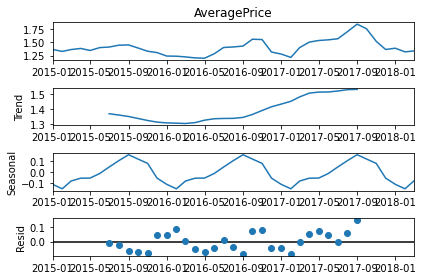

In [12]:
result = seasonal_decompose(df['AveragePrice'])
result.plot();

<AxesSubplot:xlabel='Date'>

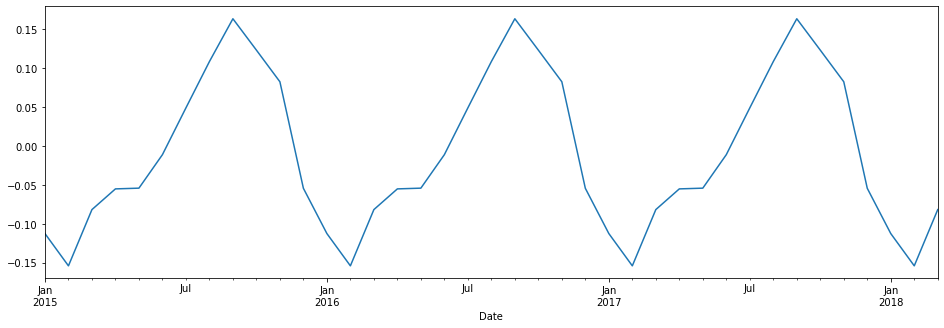

In [13]:
result.seasonal.plot(figsize=(16,5))

In [14]:
# Augmented dickey fuller test for checking the stationarity 

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [15]:
adf_test(df['AveragePrice'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.986463
p-value                  0.036178
# lags used              1.000000
# observations          37.000000
critical value (1%)     -3.620918
critical value (5%)     -2.943539
critical value (10%)    -2.610400
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [16]:
auto_arima(df['AveragePrice'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   39
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  23.612
Date:                            Wed, 07 Apr 2021   AIC                            -43.224
Time:                                    14:20:51   BIC                            -40.708
Sample:                                         0   HQIC                           -42.499
                                             - 39                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6588      0.233     -2.825      0.005      -1.116      -0.202
sigma2         0.0073      0.003      2.454      0.014       0.001       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):                 0.30
Prob(Q):                              0.39   Prob(JB):                         0.86
Heteroskedasticity (H):               2.90   Skew:                            -0.26
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
df.shape

(39, 1)

In [18]:
train =df.iloc[:27]
test = df.iloc[27:]

In [19]:
model = SARIMAX(df['AveragePrice'],order=(0,1,0),seasonal_order=(1,1,0,12))

In [20]:
result = model.fit()

In [21]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       AveragePrice   No. Observations:                   39
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  23.612
Date:                            Wed, 07 Apr 2021   AIC                            -43.224
Time:                                    14:20:51   BIC                            -40.708
Sample:                                01-01-2015   HQIC                           -42.499
                                     - 03-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6588      0.233     -2.825      0.005      -1.116      -0.202
sigma2         0.0073      0.003      2.454      0.014       0.001       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):                 0.30
Prob(Q):                              0.39   Prob(JB):                         0.86
Heteroskedasticity (H):               2.90   Skew:                            -0.26
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
start = len(train)
end = len(train)+len(test)-1
prediction = result.predict(start,end,typ = 'levels').rename('SARIMAX Prediction of test Data')

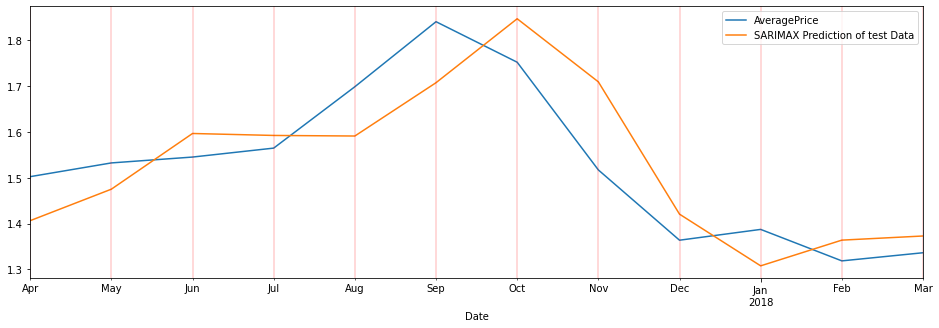

In [30]:
ax = test['AveragePrice'].plot(figsize=(16,5),legend=True)
prediction.plot(legend=True)
for month in test.index:
    ax.axvline(x=month,color='red',alpha=0.2)

In [24]:
from sklearn.metrics import mean_squared_error

In [25]:
mean_squared_error(test['AveragePrice'],prediction)

0.008684232902614584

In [26]:
np.sqrt(mean_squared_error(test['AveragePrice'],prediction))

0.09318923168807963

In [31]:
test['AveragePrice'].mean()

1.5301344117858164

## Exploratory data analysis

In [107]:
df = pd.read_csv('avocado.csv',index_col = 'Date',parse_dates=True)

In [110]:
df.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,
2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [109]:
# Let's drop the unnamed:0 column
del(df['Unnamed: 0'])

In [39]:
import matplotlib.pyplot as plt

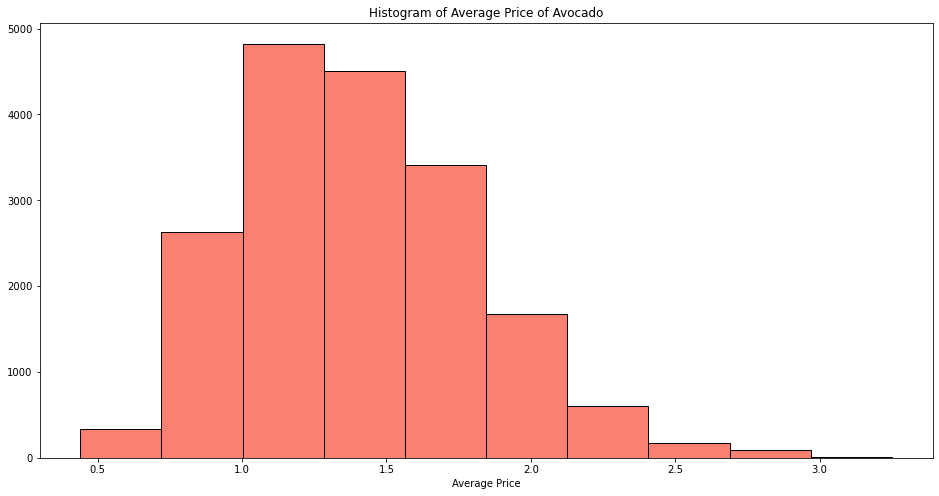

In [47]:
plt.figure(figsize=(16,8))
plt.hist(df['AveragePrice'],facecolor='salmon',edgecolor='black')
plt.title('Histogram of Average Price of Avocado')
plt.xlabel('Average Price')
plt.show()

In [49]:
import seaborn as sns

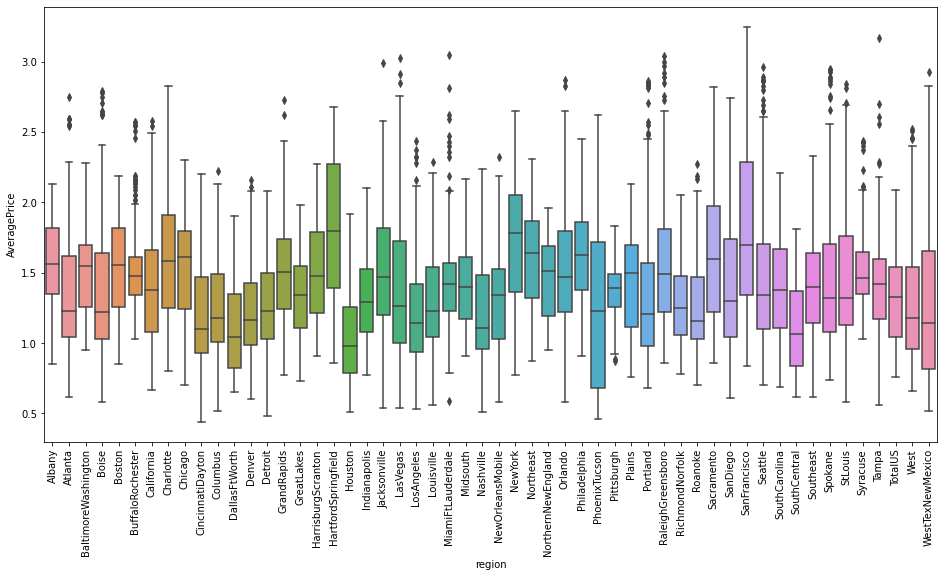

In [54]:
plt.figure(figsize=(16,8))
sns.boxplot(x = df['region'],y = df['AveragePrice'])
plt.xticks(rotation=90)
plt.show()

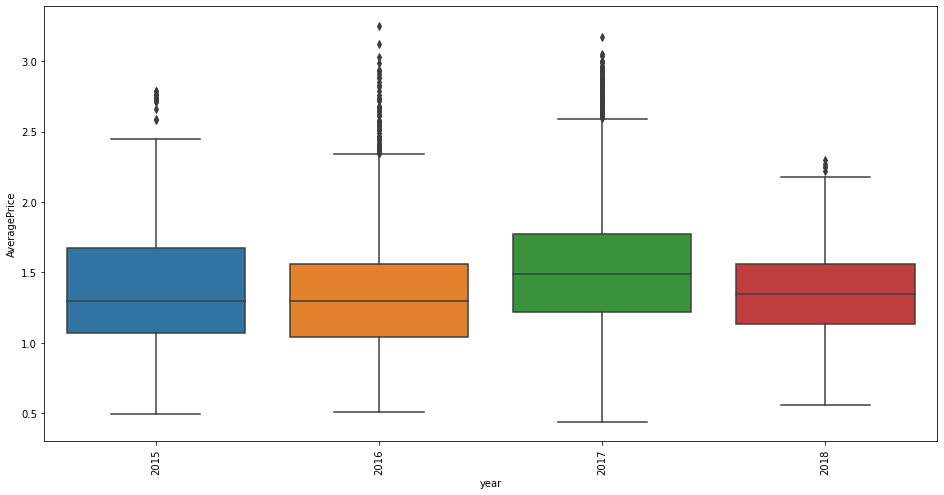

In [55]:
plt.figure(figsize=(16,8))
sns.boxplot(x = df['year'],y = df['AveragePrice'])
plt.xticks(rotation=90)
plt.show()

In [59]:
df = df.reset_index()

In [62]:
df['Year'] =  df['Date'].dt.year
df['Month'] =  df['Date'].dt.month
df['Day'] =  df['Date'].dt.day

In [64]:
df = df.set_index('Date')

In [65]:
df.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Year,Month,Day
Date,,,,,,,,,,,,,,,
2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,2015,12,27
2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,2015,12,20
2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,2015,12,13
2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,2015,12,6
2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,2015,11,29


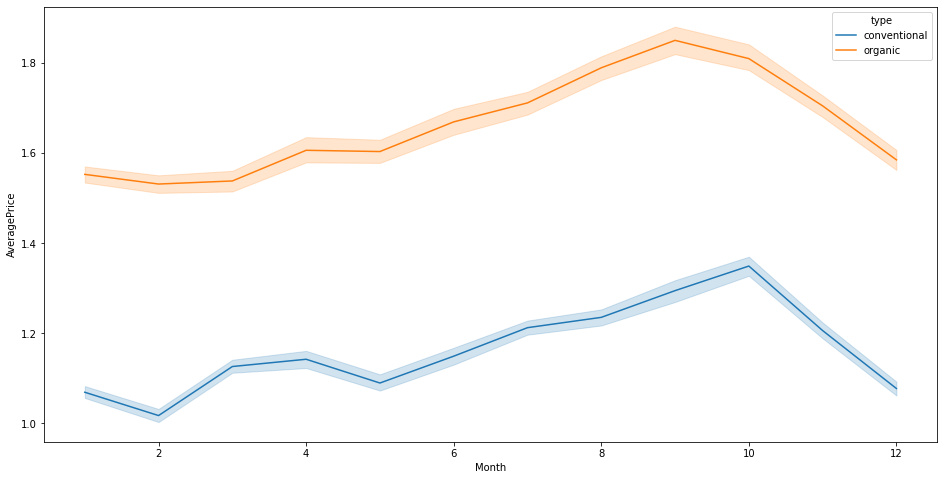

In [71]:
plt.figure(figsize=(16,8))
sns.lineplot(x = 'Month',y = 'AveragePrice', hue = 'type',data = df)
plt.show()

In [76]:
import calendar

In [77]:
calendar.month_name[1]

'January'

In [80]:
month_name = []
for index in df['Month']:
    name = calendar.month_name[index]
    month_name.append(name)

In [83]:
df['months_name'] = np.array(month_name)
df.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Year,Month,Day,months_name
Date,,,,,,,,,,,,,,,,
2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,2015,12,27,December
2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,2015,12,20,December
2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,2015,12,13,December
2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,2015,12,6,December
2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,2015,11,29,November


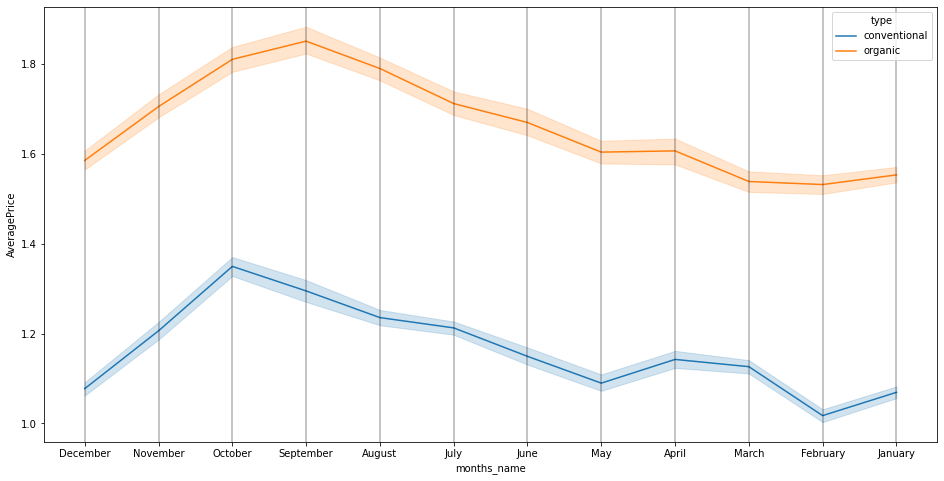

In [90]:
plt.figure(figsize=(16,8))
ax = sns.lineplot(x = 'months_name',y = 'AveragePrice', hue = 'type',data = df)
for month in df['months_name'].unique():
    ax.axvline(x = month,color = 'k',alpha=0.3)
plt.show()

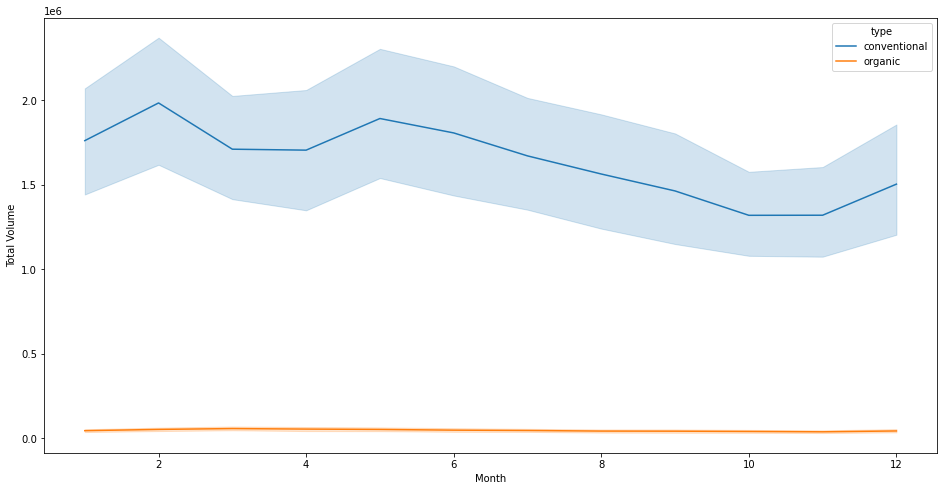

In [92]:
plt.figure(figsize=(16,8))
sns.lineplot(x = 'Month',y = 'Total Volume', hue = 'type',data = df)
plt.show()

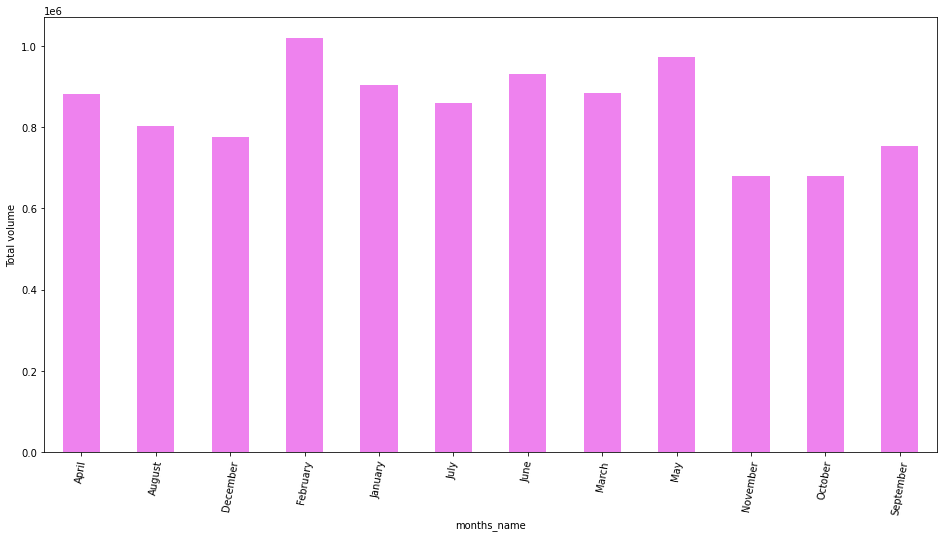

In [105]:
plt.figure(figsize=(16,8))
df.groupby(by = 'months_name')['Total Volume'].mean().plot(kind = 'bar',color='violet')
plt.ylabel('Total volume')
plt.xticks(rotation = 80);

## Thanks for viewing my repository